In [927]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from keras import layers, losses
from sklearn.model_selection import train_test_split
from keras.models import Model
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

import warnings
warnings.filterwarnings('ignore')


In [928]:
test_name = '5_epochs_FL'#'descentralized_all_w_local_training_wo_global_data'
loss = 'mse'
model = 'All'
model_type = 'CNN'

datas = []
for i in ['train', 'evaluate_before_train', 'evaluate']:

    file = f'/home/gabrieltalasso/IoT_Anomaly_Detection/logs/SKAB/{model_type}/{test_name}/{i}/loss_{loss}_{model}.csv'
    names = ['cid', 'round', 'loss','diff', 'anomaly', 'anomaly2']

    data = pd.read_csv(file,
                    names = names)
    
    datas.append(data)

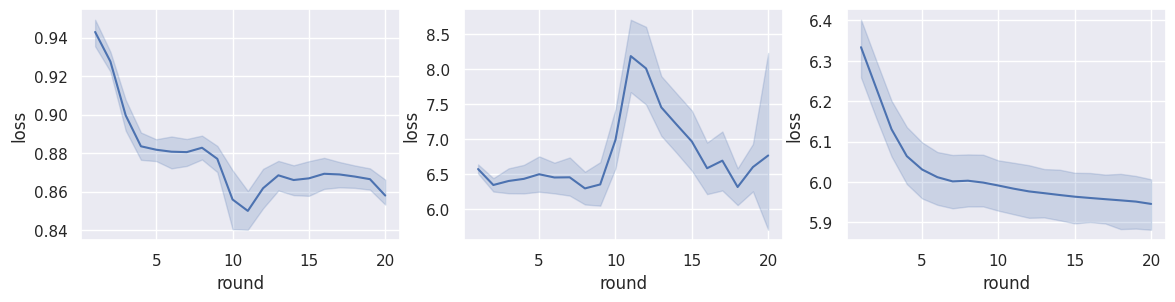

In [929]:
fig, axs = plt.subplots(1, 3, figsize=(14, 3))

for i in range(3):
    sns.lineplot(datas[i], x = 'round', y = 'loss', ax = axs[i])#, hue='cid', alpha = 0.3)

<AxesSubplot:xlabel='round', ylabel='loss'>

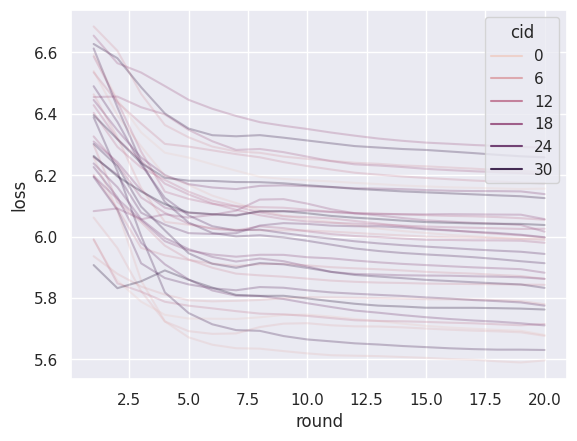

In [930]:
sns.lineplot(datas[2], x = 'round', y = 'loss', hue='cid', alpha = 0.3)

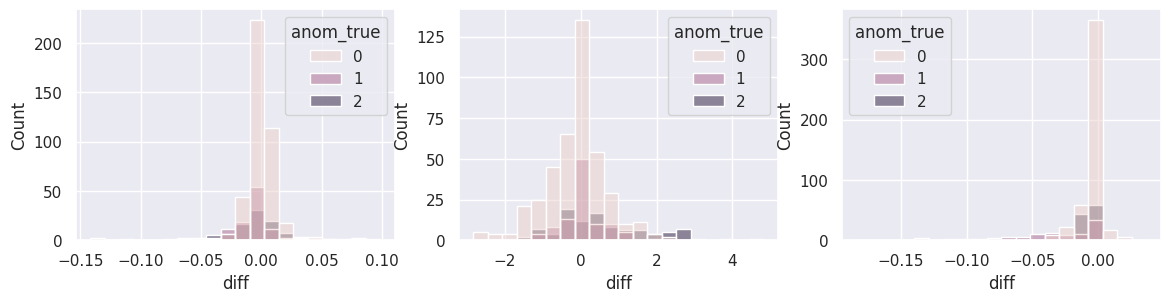

In [931]:
fig, axs = plt.subplots(1, 3, figsize=(14, 3))

for i in range(3):
    datas[i]['anom_true'] = datas[i]['round'].apply(lambda x: 1 if x==3 or x==4 or x==5 else (2 if x==12 or x==10 or x==11 else 0))
    sns.histplot(x = datas[i]['diff'], hue = datas[i]['anom_true'], bins = 20, ax = axs[i])

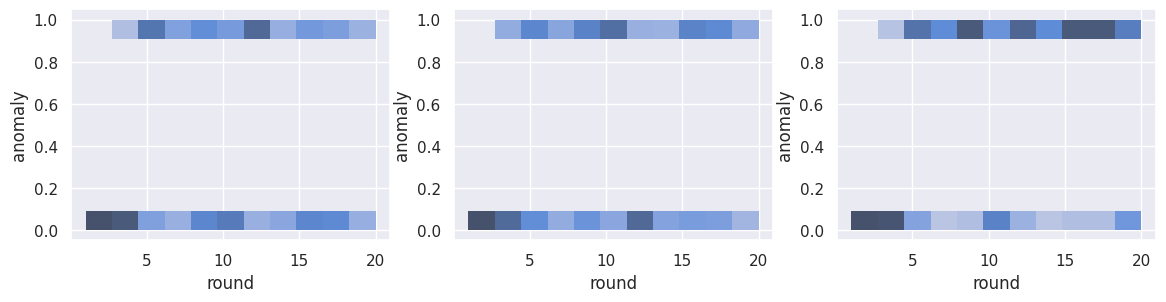

In [932]:
fig, axs = plt.subplots(1, 3, figsize=(14, 3))

for i in range(3):
    sns.histplot(x = datas[i]['round'], y = datas[i]['anomaly'], ax = axs[i])#, hue = data['anom_true'], bins = 20)

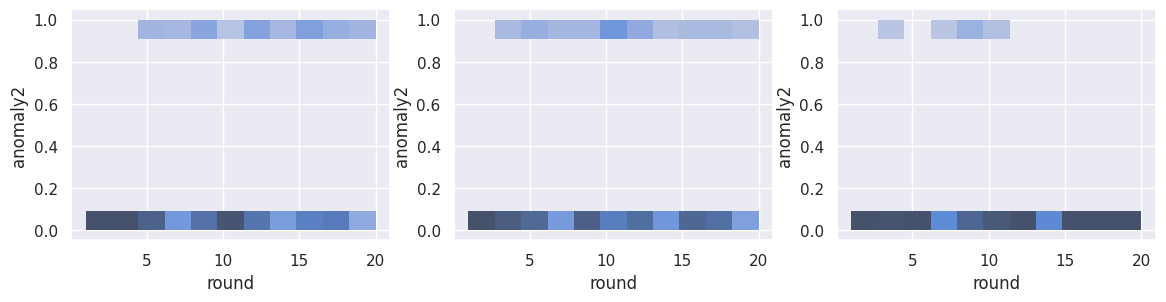

In [933]:
fig, axs = plt.subplots(1, 3, figsize=(14, 3))

for i in range(3):
    sns.histplot(x = datas[i]['round'], y = datas[i]['anomaly2'], ax = axs[i])#, hue = data['anom_true'], bins = 20)

In [934]:
for i in range(3):

    data = datas[i]
    data['true_anomaly'] = data['round'].apply(lambda x: 1 if x>=9 else 0)

    data['anomaly12'] = data['anomaly'] + data['anomaly2'] 
    data['anomaly12'] = data['anomaly12'].apply(lambda x: 1 if x==2 else x)

    print('Anomaly1 ',f1_score(data['anomaly'], data['true_anomaly']),
        precision_score(data['anomaly'], data['true_anomaly']),
        recall_score(data['anomaly'], data['true_anomaly']),
        accuracy_score(data['anomaly'], data['true_anomaly']))

    print('Anomaly2 ',f1_score(data['anomaly2'], data['true_anomaly']),
        precision_score(data['anomaly2'], data['true_anomaly']),
        recall_score(data['anomaly2'], data['true_anomaly']),
        accuracy_score(data['anomaly2'], data['true_anomaly']))
    
    print('Anomaly12 ',f1_score(data['anomaly12'], data['true_anomaly']),
        precision_score(data['anomaly12'], data['true_anomaly']),
        recall_score(data['anomaly12'], data['true_anomaly']),
        accuracy_score(data['anomaly12'], data['true_anomaly']))
    
    print('-----------')



Anomaly1  0.5496688741721855 0.4797687861271676 0.6434108527131783 0.5598705501618123
Anomaly2  0.3660130718954248 0.24277456647398843 0.7433628318584071 0.529126213592233
Anomaly12  0.6132075471698114 0.5635838150289018 0.6724137931034483 0.6019417475728155
-----------
Anomaly1  0.6019417475728155 0.5375722543352601 0.6838235294117647 0.6019417475728155
Anomaly2  0.3104212860310422 0.2023121387283237 0.6666666666666666 0.4967637540453074
Anomaly12  0.6300940438871474 0.5809248554913294 0.6883561643835616 0.6181229773462783
-----------
Anomaly1  0.7485101311084624 0.7696078431372549 0.728538283062645 0.6897058823529412
Anomaly2  0.056338028169014086 0.029411764705882353 0.6666666666666666 0.4088235294117647
Anomaly12  0.757396449704142 0.7843137254901961 0.7322654462242563 0.6985294117647058
-----------


In [935]:
#DESCENTRALIZED
# Anomaly1  0.5519591141396933 0.4682080924855491 0.6721991701244814 0.5744336569579288
# Anomaly2  0.3891213389121339 0.26878612716763006 0.7045454545454546 0.5275080906148867
# Anomaly12  0.6309148264984227 0.5780346820809249 0.6944444444444444 0.6213592233009708
# -----------
# Anomaly1  0.5792880258899676 0.5173410404624278 0.6580882352941176 0.5792880258899676
# Anomaly2  0.2945054945054945 0.1936416184971098 0.6146788990825688 0.48058252427184467
# Anomaly12  0.6122448979591837 0.5635838150289018 0.6701030927835051 0.6003236245954693
# -----------
# Anomaly1  0.6382393397524071 0.5686274509803921 0.7272727272727273 0.6132352941176471
# Anomaly2  0.27722772277227725 0.1715686274509804 0.7216494845360825 0.4632352941176471
# Anomaly12  0.6457765667574932 0.5808823529411765 0.7269938650306749 0.6176470588235294
# -----------


#Decoder (não é para haver diferença)
# Anomaly1  0.547008547008547 0.4624277456647399 0.6694560669456067 0.5711974110032363
# Anomaly2  0.3958333333333333 0.2745664739884393 0.7089552238805971 0.5307443365695793
# Anomaly12  0.6287519747235387 0.5751445086705202 0.6933797909407665 0.6197411003236246
# -----------
# Anomaly1  0.5886178861788617 0.523121387283237 0.6728624535315985 0.5906148867313916
# Anomaly2  0.2806236080178174 0.18208092485549132 0.6116504854368932 0.4773462783171521
# Anomaly12  0.611023622047244 0.5606936416184971 0.671280276816609 0.6003236245954693
# -----------
# Anomaly1  0.603085553997195 0.5269607843137255 0.7049180327868853 0.5838235294117647
# Anomaly2  0.2505050505050505 0.15196078431372548 0.7126436781609196 0.45441176470588235
# Anomaly12  0.611111111111111 0.5392156862745098 0.7051282051282052 0.5882352941176471
# -----------

In [936]:
#CENTRALIZED
#Anomaly1  0.5960264900662252 0.5769230769230769 0.6164383561643836 0.6383399209486166
#Anomaly2  0.3855421686746988 0.27350427350427353 0.6530612244897959 0.5968379446640316
#Anomaly12  0.6289308176100629 0.6410256410256411 0.6172839506172839 0.650197628458498


In [937]:
#evaluate - wo PCA All
#Anomaly1  0.7466216216216216 0.8125 0.690625 0.7242647058823529
#Anomaly2  0.08304498269896195 0.04411764705882353 0.7058823529411765 0.5128676470588235
#Anomaly12  0.7504187604690116 0.8235294117647058 0.6892307692307692 0.7261029411764706

#running again:
#Anomaly1  0.7952380952380952 0.8186274509803921 0.7731481481481481 0.7470588235294118
#Anomaly2  0.13513513513513514 0.07352941176470588 0.8333333333333334 0.43529411764705883
#Anomaly12  0.8112543962485346 0.8480392156862745 0.7775280898876404 0.763235294117647

## running again:
# Anomaly1  0.7484811664641555 0.7549019607843137 0.7421686746987952 0.6955882352941176
# Anomaly2  0.2226980728051392 0.12745098039215685 0.8813559322033898 0.4661764705882353
# Anomaly12  0.7748815165876777 0.8014705882352942 0.75 0.7205882352941176

# train- wo Decoder
#Anomaly1  0.547008547008547 0.4624277456647399 0.6694560669456067 0.5711974110032363
#Anomaly2  0.4024896265560166 0.28034682080924855 0.7132352941176471 0.5339805825242718
#Anomaly12  0.6330708661417322 0.5809248554913294 0.6955017301038062 0.6229773462783171

#evaluate - wo PCA Encoder
#Anomaly1  0.6337448559670782 0.5661764705882353 0.719626168224299 0.6073529411764705
#Anomaly2  0.27218934911242604 0.16911764705882354 0.696969696969697 0.4573529411764706
#Anomaly12  0.645945945945946 0.5857843137254902 0.7198795180722891 0.6147058823529412


In [938]:
#evaluate - PCA2 All
#Anomaly1  0.6947040498442366 0.6861538461538461 0.7034700315457413 0.6716917922948074
#Anomaly2  0.1758241758241758 0.09846153846153846 0.8205128205128205 0.49748743718592964
#Anomaly12  0.7127496159754224 0.7138461538461538 0.7116564417177914 0.6867671691792295

#evaluate before train- PCA2 Decoder
#Anomaly1  0.5945072697899838 0.5317919075144508 0.673992673992674 0.5938511326860841
#Anomaly2  0.29074889867841414 0.1907514450867052 0.6111111111111112 0.47896440129449835
#Anomaly12  0.6151419558359622 0.5635838150289018 0.6770833333333334 0.6051779935275081

In [939]:
#evaluate - PCA3 All
#Anomaly1  0.7166454891994918 0.6911764705882353 0.7440633245382586 0.6720588235294118
#Anomaly2  0.25157232704402516 0.14705882352941177 0.8695652173913043 0.475
#Anomaly12  0.7338308457711443 0.7230392156862745 0.7449494949494949 0.6852941176470588

In [940]:
#evaluate - PCA4 All
#Anomaly1  0.7300380228136881 0.7058823529411765 0.7559055118110236 0.6867647058823529
#Anomaly2  0.18454935622317598 0.1053921568627451 0.7413793103448276 0.4411764705882353
#Anomaly12  0.7390761548064918 0.7254901960784313 0.7531806615776081 0.6926470588235294

In [941]:
#evaluate - PCA8 All
#Anomaly1  0.7688564476885644 0.7745098039215687 0.7632850241545893 0.7205882352941176
#Anomaly2  0.21397379912663755 0.12009803921568628 0.98 0.47058823529411764
#Anomaly12  0.7792521109770807 0.7916666666666666 0.7672209026128266 0.7308823529411764

In [948]:
for i in range(3):

    df = datas[i].copy()
    df['anomaly'] = 0
    df['anomaly2'] = 0
    df['anomaly3'] = 0
    df['anomaly12'] = 0

    df['true_anomaly'] = df['round'].apply(lambda x: 1 if x>=9 else 0)

    th = 1.5

    for cid in range(34):
        for r in range(1, 20):

            if r>3:
                try:
                    diff = df[(df['cid'] == cid) & (df['round'] == r)]['diff'].values[0]

                    diff1 = df[(df['cid'] == cid) & (df['round'] == r-1)]['diff'].values[0]
                    diff2 = df[(df['cid'] == cid) & (df['round'] == r-2)]['diff'].values[0]
                    diff3 = df[(df['cid'] == cid) & (df['round'] == r-3)]['diff'].values[0]
                    mean_diff = np.mean([diff1, diff2, diff3])

                    anomaly = 0
                    if diff >= th*mean_diff: #se cresceu mais que o esperado, é a nomalia
                        anomaly = 1

                    idx = df[(df['cid'] == cid) & (df['round'] == r)].index.values[0] 
                    df.at[idx, 'anomaly']= anomaly


                    diff = abs(df[(df['cid'] == cid) & (df['round'] == r)]['diff'].values[0])

                    diff1 = abs(df[(df['cid'] == cid) & (df['round'] == r-1)]['diff'].values[0])
                    diff2 = abs(df[(df['cid'] == cid) & (df['round'] == r-2)]['diff'].values[0])
                    diff3 = abs(df[(df['cid'] == cid) & (df['round'] == r-3)]['diff'].values[0])
                    mean_diff = np.mean([diff1, diff2, diff3])

                    anomaly3 = 0
                    if diff <= th*mean_diff: #se cresceu mais que o esperado, é a nomalia
                        anomaly3 = 1

                    idx = df[(df['cid'] == cid) & (df['round'] == r)].index.values[0] 
                    df.at[idx, 'anomaly3']= anomaly3

                    anomaly2 = 0
                    loss =  df[(df['cid'] == cid) & (df['round'] == r)]['loss'].values[0]
                    last_losses1 = df[(df['cid'] == cid) & (df['round'] == r-1)]['loss'].values[0]
                    last_losses2 = df[(df['cid'] == cid) & (df['round'] == r-2)]['loss'].values[0]

                    if (loss - last_losses1) > 0:
                        if (last_losses1 - last_losses2) > 0:
                            anomaly2 = 1 
                    idx = df[(df['cid'] == cid) & (df['round'] == r)].index.values[0] 
                    df.at[idx, 'anomaly2']= anomaly2

                except IndexError:
                    anomaly = df[df['cid'] == cid]['anomaly'].tail(1).values[0]

    df['anomaly12'] = df['anomaly'] + df['anomaly2'] 
    df['anomaly12'] = df['anomaly12'].apply(lambda x: 1 if x==2 else x)

    df['anomaly32'] = df['anomaly2'] + df['anomaly3'] 
    df['anomaly32'] = df['anomaly32'].apply(lambda x: 1 if x==2 else x)

    data = df.copy()
    print('Anomaly1 ',f1_score(df['anomaly'], data['true_anomaly']),
        precision_score(data['anomaly'], data['true_anomaly']),
        recall_score(data['anomaly'], data['true_anomaly']),
        accuracy_score(data['anomaly'], data['true_anomaly']))

    print('Anomaly2 ',f1_score(data['anomaly2'], data['true_anomaly']),
        precision_score(data['anomaly2'], data['true_anomaly']),
        recall_score(data['anomaly2'], data['true_anomaly']),
        accuracy_score(data['anomaly2'], data['true_anomaly']))
    
    print('Anomaly3 ',f1_score(data['anomaly3'], data['true_anomaly']),
        precision_score(data['anomaly3'], data['true_anomaly']),
        recall_score(data['anomaly3'], data['true_anomaly']),
        accuracy_score(data['anomaly3'], data['true_anomaly']))
    
    print('Anomaly12 ',f1_score(data['anomaly12'], data['true_anomaly']),
        precision_score(data['anomaly12'], data['true_anomaly']),
        recall_score(data['anomaly12'], data['true_anomaly']),
        accuracy_score(data['anomaly12'], data['true_anomaly']))
    
    print('Anomaly32 ',f1_score(data['anomaly32'], data['true_anomaly']),
        precision_score(data['anomaly32'], data['true_anomaly']),
        recall_score(data['anomaly32'], data['true_anomaly']),
        accuracy_score(data['anomaly32'], data['true_anomaly']))
    
    print('-----------')


Anomaly1  0.3375959079283888 0.4852941176470588 0.25882352941176473 0.580906148867314
Anomaly2  0.13654618473895583 0.125 0.1504424778761062 0.6521035598705501
Anomaly3  0.36734693877551017 0.6617647058823529 0.2542372881355932 0.49838187702265374
Anomaly12  0.326241134751773 0.5073529411764706 0.24041811846689895 0.5388349514563107
Anomaly32  0.3668639053254438 0.6838235294117647 0.25067385444743934 0.48058252427184467
-----------
Anomaly1  0.38916256157635465 0.5808823529411765 0.29259259259259257 0.598705501618123
Anomaly2  0.3833333333333333 0.3382352941176471 0.4423076923076923 0.7605177993527508
Anomaly3  0.4043956043956044 0.6764705882352942 0.2884012539184953 0.5614886731391586
Anomaly12  0.4272300469483568 0.6691176470588235 0.3137931034482759 0.6051779935275081
Anomaly32  0.4426559356136821 0.8088235294117647 0.3047091412742382 0.551779935275081
-----------
Anomaly1  0.3037974683544304 0.6176470588235294 0.2014388489208633 0.4338235294117647
Anomaly2  0.15584415584415584 0.08

In [943]:
Anomaly32  0.8107448107448108 0.9595375722543352 0.7019027484143763 0.7491909385113269
Anomaly32  0.7734375000000001 0.8583815028901735 0.7037914691943128 0.7184466019417476


SyntaxError: invalid syntax (2466211394.py, line 1)

In [ ]:
Anomaly1  0.6386292834890965 0.5924855491329479 0.6925675675675675 0.6245954692556634
Anomaly2  0.32967032967032966 0.21676300578034682 0.6880733944954128 0.5064724919093851
Anomaly3  0.7431059506531204 0.7398843930635838 0.7463556851311953 0.7135922330097088
Anomaly12  0.6616084977238239 0.630057803468208 0.6964856230031949 0.63915857605178
Anomaly32  0.7690355329949239 0.8757225433526011 0.6855203619909502 0.7055016181229773
-----------
Anomaly1  0.5704697986577182 0.4913294797687861 0.68 0.5857605177993528
Anomaly2  0.28378378378378377 0.18208092485549132 0.6428571428571429 0.4854368932038835
Anomaly3  0.7817403708987162 0.791907514450867 0.7718309859154929 0.7524271844660194
Anomaly12  0.6166134185303515 0.5578034682080925 0.6892857142857143 0.6116504854368932
Anomaly32  0.789407313997478 0.9046242774566474 0.7002237136465325 0.7297734627831716
-----------
Anomaly1  0.5595408895265424 0.47794117647058826 0.6747404844290658 0.5485294117647059
Anomaly2  0.2540322580645161 0.15441176470588236 0.7159090909090909 0.45588235294117646
Anomaly3  0.755 0.7401960784313726 0.7704081632653061 0.711764705882353
Anomaly12  0.5806451612903225 0.5073529411764706 0.6786885245901639 0.5602941176470588
Anomaly32  0.7777777777777778 0.8406862745098039 0.7236286919831224 0.711764705882353

SyntaxError: invalid syntax (3099225111.py, line 1)

In [ ]:
#ours

# Anomaly1  0.5319516407599308 0.44508670520231214 0.6609442060085837 0.5614886731391586
# Anomaly2  0.3891213389121339 0.26878612716763006 0.7045454545454546 0.5275080906148867
# Anomaly3  0.792189679218968 0.8208092485549133 0.7654986522911051 0.7588996763754046
# Anomaly12  0.6246056782334385 0.5722543352601156 0.6875 0.6148867313915858
# Anomaly32  0.7797927461139896 0.869942196531792 0.7065727699530516 0.7249190938511327
# -----------
# Anomaly1  0.598705501618123 0.5346820809248555 0.6801470588235294 0.598705501618123
# Anomaly2  0.28699551569506726 0.18497109826589594 0.64 0.4854368932038835
# Anomaly3  0.8022598870056499 0.8208092485549133 0.7845303867403315 0.7734627831715211
# Anomaly12  0.632398753894081 0.5867052023121387 0.6858108108108109 0.6181229773462783
# Anomaly32  0.8045685279187818 0.9161849710982659 0.7171945701357466 0.7508090614886731
# -----------
# Anomaly1  0.733173076923077 0.7475490196078431 0.7193396226415094 0.6735294117647059
# Anomaly2  0.1956521739130435 0.11029411764705882 0.8653846153846154 0.45588235294117646
# Anomaly3  0.7803203661327232 0.8357843137254902 0.7317596566523605 0.7176470588235294
# Anomaly12  0.7654609101516919 0.803921568627451 0.7305122494432071 0.7044117647058824
# Anomaly32  0.7851518560179978 0.8553921568627451 0.7255717255717256 0.7191176470588235



#centralized
#Anomaly1  0.5441860465116278 0.5 0.5969387755102041 0.6126482213438735
#Anomaly2  0.2990654205607477 0.20512820512820512 0.5517241379310345 0.5553359683794467
#Anomaly3  0.7231404958677686 0.7478632478632479 0.7 0.7351778656126482
#Anomaly12  0.5846153846153846 0.5683760683760684 0.6018099547511312 0.6264822134387352
#Anomaly32  0.7186932849364791 0.8461538461538461 0.6246056782334385 0.6936758893280632
#-----------
#Anomaly1  0.5688888888888889 0.5470085470085471 0.5925925925925926 0.616600790513834
#Anomaly2  0.32628398791540786 0.23076923076923078 0.5567010309278351 0.5592885375494071
#Anomaly3  0.721868365180467 0.7264957264957265 0.7172995780590717 0.741106719367589
#Anomaly12  0.5854700854700855 0.5854700854700855 0.5854700854700855 0.616600790513834
#Anomaly32  0.7433628318584071 0.8974358974358975 0.6344410876132931 0.7134387351778656
#-----------
#Anomaly1  0.5960264900662252 0.5769230769230769 0.6164383561643836 0.6383399209486166
#Anomaly2  0.3855421686746988 0.27350427350427353 0.6530612244897959 0.5968379446640316
#Anomaly3  0.6666666666666666 0.6581196581196581 0.6754385964912281 0.6956521739130435
#Anomaly12  0.6289308176100629 0.6410256410256411 0.6172839506172839 0.650197628458498
#Anomaly32  0.7349823321554769 0.8888888888888888 0.6265060240963856 0.7035573122529645